# Problem and Data Description

## 1. Competition Overview

The ["GANs: Getting Started"](https://www.kaggle.com/competitions/gan-getting-started) Kaggle competition challenges participants to generate Monet-style images using Generative Adversarial Networks (GANs). This is an image-to-image translation problem where we transform regular photographs into images that mimic Claude Monet's distinctive impressionist style.

## 2. Problem Statement

### Objective
Generate 7,000-10,000 images in the style of Monet paintings that achieve a low MiFID score.

### Evaluation Metric
**Memorization-informed Fréchet Inception Distance (MiFID)**: A measure of similarity between generated images and real Monet paintings. Lower scores indicate better performance.

The MiFID score extends the traditional FID metric by penalizing direct copying or memorization of the training data. This ensures that models are truly learning to generate new Monet-style images rather than simply reproducing the training examples.

### Submission Requirements
- A zip file containing 7,000-10,000 JPEG images (256x256 pixels)
- Each image should resemble a Monet painting in style

## 3. Dataset Description

The competition provides the dataset in two formats:

1. **JPEG Format**:
   - `monet_jpg/`: 300 Monet artwork images (256x256 pixels)
   - `photo_jpg/`: 7,038 natural photos (256x256 pixels)

2. **TFRecord Format** (same images, different format):
   - `monet_tfrec/`: The same 300 Monet paintings in TFRecord format
   - `photo_tfrec/`: The same 7,038 photos in TFRecord format

The TFRecord format is optimized for TensorFlow, while the JPEG format is more universally accessible. You can use either format depending on your implementation preference.

## 4. Setup Dependencies

Before running the code cells, ensure you have the necessary packages installed:

In [1]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set paths (adjust as needed for your environment)
MONET_JPG_PATH = "../data/monet_jpg/"
PHOTO_JPG_PATH = "../data/photo_jpg/"
MONET_TFREC_PATH = "../data/monet_tfrec/"
PHOTO_TFREC_PATH = "../data/photo_tfrec/"

2025-03-18 07:09:23.762870: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Function to load and display images
def load_image(image_path):
    """Load and normalize an image from a file path."""
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0,1]
    return img

def display_images(monet_paths, photo_paths, n=3):
    """Display n Monet paintings and n photos side by side."""
    plt.figure(figsize=(15, 5))
    
    # Display Monet paintings
    for i in range(n):
        plt.subplot(2, n, i+1)
        img = load_image(monet_paths[i])
        plt.imshow(img)
        plt.title(f"Monet {i+1}")
        plt.axis('off')
    
    # Display photos
    for i in range(n):
        plt.subplot(2, n, n+i+1)
        img = load_image(photo_paths[i])
        plt.imshow(img)
        plt.title(f"Photo {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

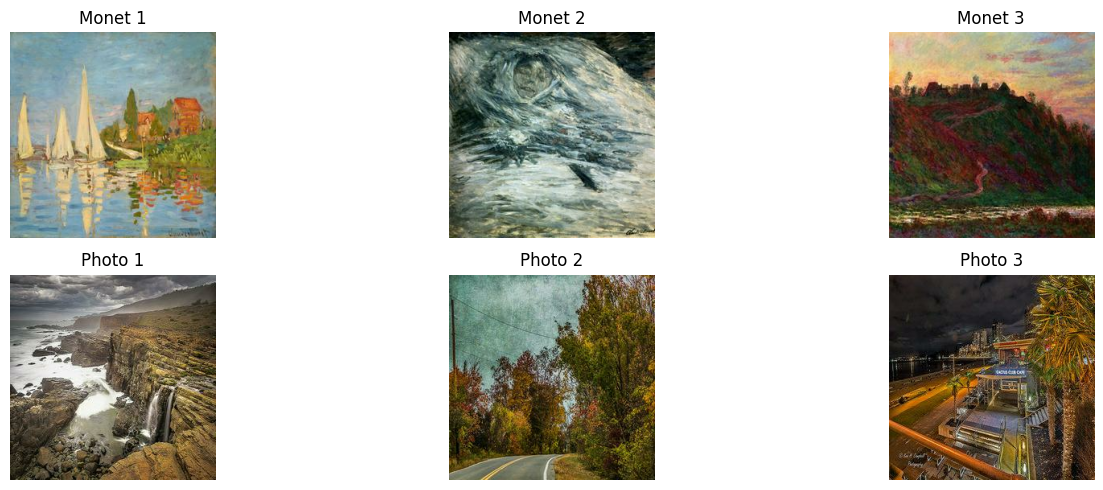

Total Monet paintings: 300
Total photos: 7038


In [3]:
# Get sample image paths and display them
# Note: This code assumes the data has been downloaded and placed in the specified directories
# If running in Kaggle, adjust paths accordingly

try:
    monet_files = [os.path.join(MONET_JPG_PATH, f) for f in os.listdir(MONET_JPG_PATH) if f.endswith('.jpg')][:3]
    photo_files = [os.path.join(PHOTO_JPG_PATH, f) for f in os.listdir(PHOTO_JPG_PATH) if f.endswith('.jpg')][:3]
    
    # Display sample images
    display_images(monet_files, photo_files)
    
    print(f"Total Monet paintings: {len([f for f in os.listdir(MONET_JPG_PATH) if f.endswith('.jpg')])}")
    print(f"Total photos: {len([f for f in os.listdir(PHOTO_JPG_PATH) if f.endswith('.jpg')])}")
except FileNotFoundError:
    print("Data files not found. Please download the dataset or adjust the paths.")

## 5. Data Characteristics

### Monet Paintings
- **Style**: Impressionist with visible brushstrokes
- **Color palette**: Often uses vibrant blues, greens, and purples
- **Subjects**: Landscapes, water scenes, gardens, and nature
- **Lighting**: Emphasis on natural light and its effects
- **Texture**: Distinctive brushstroke patterns that create texture

### Photographs
- **Content**: Various natural scenes and landscapes
- **Resolution**: All images are 256x256 pixels
- **Format**: RGB color images
- **Variety**: Includes different lighting conditions, seasons, and subjects

### Key Challenge
This is an **unpaired image translation** problem. We don't have direct pairs of "before/after" images (photos and their corresponding Monet-style versions). Instead, we have two separate collections and must learn the style transformation between them.

## 6. Reading TFRecord Data

If you prefer to use the TFRecord format, here's how to read the data:

In [4]:
def decode_image(image):
    """Decode and preprocess TFRecord image data."""
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    image = tf.reshape(image, [256, 256, 3])
    return image

def read_tfrecord(example):
    """Parse a single TFRecord example."""
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, features)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    """Load a TFRecord dataset."""
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Example usage (commented out to avoid execution if data isn't available)
'''
monet_ds = load_dataset(tf.io.gfile.glob(MONET_TFREC_PATH + '/*.tfrec'))
photo_ds = load_dataset(tf.io.gfile.glob(PHOTO_TFREC_PATH + '/*.tfrec'))

# Display a few examples
plt.figure(figsize=(15, 5))
for i, img in enumerate(monet_ds.take(3)):
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()
'''

"\nmonet_ds = load_dataset(tf.io.gfile.glob(MONET_TFREC_PATH + '/*.tfrec'))\nphoto_ds = load_dataset(tf.io.gfile.glob(PHOTO_TFREC_PATH + '/*.tfrec'))\n\n# Display a few examples\nplt.figure(figsize=(15, 5))\nfor i, img in enumerate(monet_ds.take(3)):\n    plt.subplot(1, 3, i+1)\n    plt.imshow(img)\n    plt.axis('off')\nplt.tight_layout()\nplt.show()\n"

## 7. Technical Approach

To address this unpaired image-to-image translation problem, we'll implement a **CycleGAN** architecture. CycleGAN is particularly well-suited for this task because:

1. **Unpaired Training**: It doesn't require paired training data, which is perfect for our scenario where we have separate collections of Monet paintings and photographs.

2. **Cycle Consistency**: It uses cycle-consistency loss to ensure that the content of the original image is preserved while the style is transformed.

3. **Bidirectional Mapping**: It learns both the photo-to-Monet and Monet-to-photo transformations simultaneously, which helps maintain the integrity of the content.

4. **Style Transfer Capability**: It has been proven effective for artistic style transfer tasks similar to our Monet painting generation.

### CycleGAN Architecture Overview

The CycleGAN architecture consists of:

- **Two Generators**: 
  - G: Transforms photos to Monet-style images
  - F: Transforms Monet-style images back to photos

- **Two Discriminators**:
  - D_X: Distinguishes real photos from generated photos
  - D_Y: Distinguishes real Monet paintings from generated Monet-style images

- **Loss Functions**:
  - Adversarial loss: Makes generated images indistinguishable from real images
  - Cycle consistency loss: Ensures x → G(x) → F(G(x)) ≈ x and y → F(y) → G(F(y)) ≈ y
  - Identity loss (optional): Helps preserve color composition when appropriate

In the next notebook, we'll perform exploratory data analysis to better understand the characteristics of Monet's style before implementing our model.